# Estimating Acceleration of Drones With Neural Networks



In [14]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt


In [15]:
# Reading in data and formatting it for the model

data = pd.read_csv('Training_Data.csv', delimiter=',')

# Drop the calculated acceleration
calc_accel = data[' Calculated_Acceleration'].to_numpy()
data.drop(columns=' Calculated_Acceleration', inplace=True)

# The target accel needs to be between 0 and 1
# adding .5 does not influence the predictions aside from this offset
data[' Logged_Acceleration'] += 0.5

# one-hot-encoding for state column
data[' State'] = data[' State'].astype(str)
data = pd.get_dummies(data)

# moving target variable back to last column after one-hot-encoding
cols = list(data.columns.values)
cols.pop(cols.index(' Logged_Acceleration'))
data = data[cols + [' Logged_Acceleration']]
print(data)

# Scaling feature data
scaler = MinMaxScaler()

data[['Current', ' Voltage', ' MR_Crater', ' MR_Peak', ' MinCrater', ' MaxPeak', ' Average']] = scaler.fit_transform(data[['Current', ' Voltage', ' MR_Crater', ' MR_Peak', ' MinCrater', ' MaxPeak', ' Average']])
print(data)

# split into X and y, with y as the target column(the +/- credit approvals)
X = data.iloc[:, :len(data.columns)-2].to_numpy()
y = data.iloc[:, (len(data.columns)-1)].to_numpy()
n_dim = len(X[1])

         Current    Voltage   MR_Crater    MR_Peak   MinCrater    MaxPeak  \
0      10.740934  11.035156   10.731553   0.000000    0.000000   0.000000   
1      10.749449  10.986328   10.731553   0.000000   10.731553   0.000000   
2      10.756581  11.083984   10.731553   0.000000   10.731553   0.000000   
3      10.761886  11.035156   10.731553   0.000000   10.731553   0.000000   
4      10.765013  10.937500   10.731553   0.000000   10.731553   0.000000   
...          ...        ...         ...        ...         ...        ...   
14028  10.533078  10.766602   10.405078  11.847396   10.405078  11.847396   
14029  10.539570  10.766602   10.405078  11.847396   10.405078  11.847396   
14030  10.544424  10.766602   10.405078  11.847396   10.405078  11.847396   
14031  10.547753  10.791016   10.405078  11.847396   10.405078  11.847396   
14032  10.549782  10.595703   10.405078  11.847396   10.405078  11.847396   

         Average   Rising   State_2   State_3   Logged_Acceleration  
0    

In [16]:
def RMSE(y_true, y_pred):
    if len(y_true) != len(y_pred):
        return -1
    rmse = 0.0
    for i in range(len(y_true)):
        rmse += (y_test[i] - y_pred[i])**2
    rmse = rmse/len(y_true)
    return rmse

# Score metrics taken from this post, 
# https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
    

# Testing models

RMSE: [0.00245705]
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 9)                 90        
_________________________________________________________________
dense_50 (Dense)             (None, 4)                 40        
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 5         
Total params: 135
Trainable params: 135
Non-trainable params: 0
_________________________________________________________________


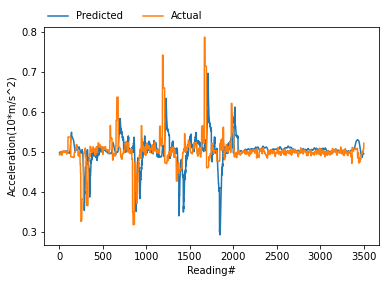

In [17]:
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X_train = X[:len(X)-3500]
X_test = X[len(X)-3500:-1]
y_train = y[:len(y)-3500]
y_test = y[len(y)-3500:-1]
#print(len(y_test))
#print(y_test)
#print(calc_accel[len(calc_accel)-len(y_test):-1])
#plt.plot(calc_accel[len(calc_accel)-len(y_test):-1])
#plt.plot(y_test)
model = Sequential()
model.add(Dense(9, input_dim=n_dim, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='mse', metrics=['acc', f1_m, precision_m, recall_m])

model.fit(X_train, y_train, epochs=50, batch_size=5, verbose=0)

y_pred = model.predict(X_test)

plt.plot(y_pred, label="Predicted")
plt.plot(y_test, label="Actual")
plt.xlabel('Reading#')
plt.ylabel('Acceleration(10*m/s^2)')
plt.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=2, borderaxespad=0, frameon=False)

rmse = RMSE(y_test, y_pred)
print("RMSE:", rmse)

model.summary()


In [ ]:
model = Sequential()
model.add(Dense(18, input_dim=n_dim, activation='sigmoid'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='mse', metrics=['acc', f1_m, precision_m, recall_m])

model.fit(X_train, y_train, epochs=80, batch_size=8, verbose=0)

y_pred = model.predict(X_test)

plt.plot(y_pred, label="Predicted")
plt.plot(y_test, label="Actual")
plt.xlabel('Reading#')
plt.ylabel('Acceleration(10*m/s^2)')
plt.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=2, borderaxespad=0, frameon=False)

rmse = RMSE(y_test, y_pred)
print("RMSE:", rmse)


The network below is the best performing NN. 

RMSE: [0.00201111]


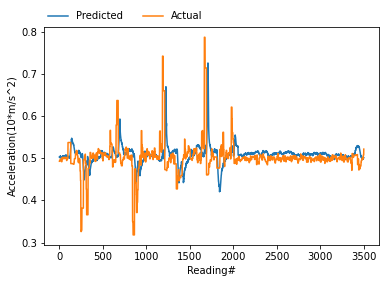

In [6]:
model = Sequential()
model.add(Dense(12, input_dim=n_dim, activation='sigmoid'))
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adadelta', loss='mse', metrics=['acc', f1_m, precision_m, recall_m])

model.fit(X_train, y_train, epochs=40, batch_size=4, verbose=0)

y_pred = model.predict(X_test)

plt.plot(y_pred, label="Predicted")
plt.plot(y_test, label="Actual")
plt.xlabel('Reading#')
plt.ylabel('Acceleration(10*m/s^2)')
plt.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=2, borderaxespad=0, frameon=False)

rmse = RMSE(y_test, y_pred)
print("RMSE:", rmse)




RMSE: [0.0031649]


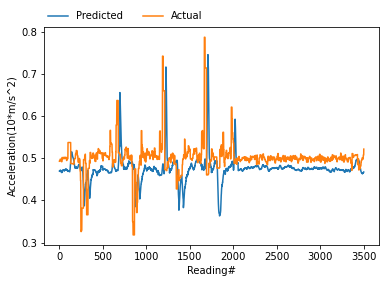

In [7]:
model = Sequential()
model.add(Dense(16, input_dim=n_dim, activation='sigmoid'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adadelta', loss='mse', metrics=['acc', f1_m, precision_m, recall_m])

model.fit(X_train, y_train, epochs=80, batch_size=5, verbose=0)

y_pred = model.predict(X_test)

plt.plot(y_pred, label="Predicted")
plt.plot(y_test, label="Actual")
plt.xlabel('Reading#')
plt.ylabel('Acceleration(10*m/s^2)')
plt.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=2, borderaxespad=0, frameon=False)

rmse = RMSE(y_test, y_pred)
print("RMSE:", rmse)

RMSE: [0.00163207]


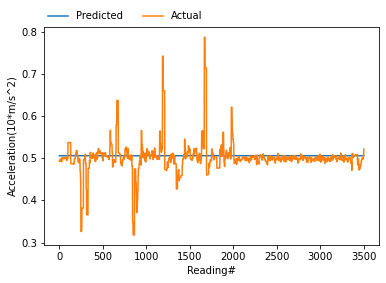

In [8]:
model = Sequential()
model.add(Dense(12, input_dim=n_dim, activation='sigmoid'))
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='mse', metrics=['acc', f1_m, precision_m, recall_m])

model.fit(X_train, y_train, epochs=40, batch_size=4, verbose=0)

y_pred = model.predict(X_test)

plt.plot(y_pred, label="Predicted")
plt.plot(y_test, label="Actual")
plt.xlabel('Reading#')
plt.ylabel('Acceleration(10*m/s^2)')
plt.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=2, borderaxespad=0, frameon=False)

rmse = RMSE(y_test, y_pred)
print("RMSE:", rmse)


RMSE: [0.00185971]


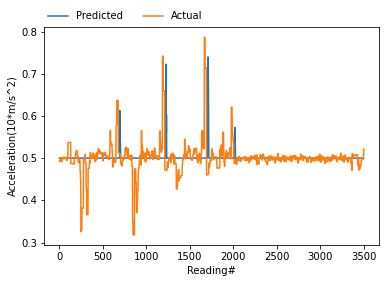

In [9]:
model = Sequential()
model.add(Dense(12, input_dim=n_dim, activation='sigmoid'))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adadelta', loss='mse', metrics=['acc', f1_m, precision_m, recall_m])

model.fit(X_train, y_train, epochs=80, batch_size=5, verbose=0)

y_pred = model.predict(X_test)

plt.plot(y_pred, label="Predicted")
plt.plot(y_test, label="Actual")
plt.xlabel('Reading#')
plt.ylabel('Acceleration(10*m/s^2)')
plt.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=2, borderaxespad=0, frameon=False)

rmse = RMSE(y_test, y_pred)
print("RMSE:", rmse)

RMSE: [0.00307268]


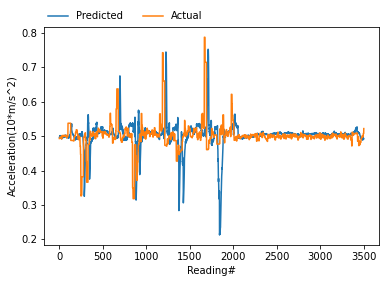

In [10]:
model = Sequential()
model.add(Dense(12, input_dim=n_dim, activation='linear'))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adadelta', loss='mse', metrics=['acc', f1_m, precision_m, recall_m])

model.fit(X_train, y_train, epochs=80, batch_size=5, verbose=0)

y_pred = model.predict(X_test)

plt.plot(y_pred, label="Predicted")
plt.plot(y_test, label="Actual")
plt.xlabel('Reading#')
plt.ylabel('Acceleration(10*m/s^2)')
plt.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=2, borderaxespad=0, frameon=False)

rmse = RMSE(y_test, y_pred)
print("RMSE:", rmse)


RMSE: [0.00161155]


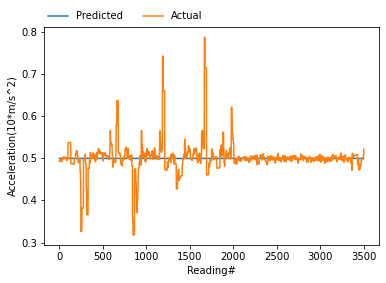

In [11]:
model = Sequential()
model.add(Dense(12, input_dim=n_dim, activation='linear'))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adadelta', loss='mse', metrics=['acc', f1_m, precision_m, recall_m])

model.fit(X_train, y_train, epochs=80, batch_size=5, verbose=0)

y_pred = model.predict(X_test)

plt.plot(y_pred, label="Predicted")
plt.plot(y_test, label="Actual")
plt.xlabel('Reading#')
plt.ylabel('Acceleration(10*m/s^2)')
plt.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=2, borderaxespad=0, frameon=False)

rmse = RMSE(y_test, y_pred)
print("RMSE:", rmse)

RMSE: [0.00311413]


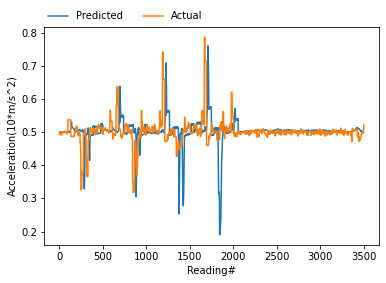

In [12]:

model = Sequential()
model.add(Dense(22, input_dim=n_dim, activation='linear'))
model.add(Dense(16, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adadelta', loss='mse', metrics=['acc', f1_m, precision_m, recall_m])

model.fit(X_train, y_train, epochs=80, batch_size=5, verbose=0)

y_pred = model.predict(X_test)

plt.plot(y_pred, label="Predicted")
plt.plot(y_test, label="Actual")
plt.xlabel('Reading#')
plt.ylabel('Acceleration(10*m/s^2)')
plt.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=2, borderaxespad=0, frameon=False)

rmse = RMSE(y_test, y_pred)
print("RMSE:", rmse)


RMSE: [0.0028771]


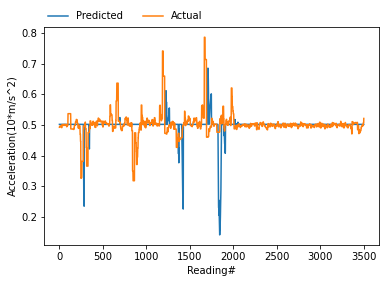

In [13]:
# Trying the best performing model so far but with more epochs
model = Sequential()
model.add(Dense(12, input_dim=n_dim, activation='linear'))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adadelta', loss='mse', metrics=['acc', f1_m, precision_m, recall_m])

model.fit(X_train, y_train, epochs=200, batch_size=5, verbose=0)

y_pred = model.predict(X_test)

plt.plot(y_pred, label="Predicted")
plt.plot(y_test, label="Actual")
plt.xlabel('Reading#')
plt.ylabel('Acceleration(10*m/s^2)')
plt.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=2, borderaxespad=0, frameon=False)

rmse = RMSE(y_test, y_pred)
print("RMSE:", rmse)